In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [3]:
sys.path.insert(0, '../src')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../src/chebyshev.pyc'>

# Load ROM

In [4]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [5]:
for lam in linspace(50, 5000, 10):
    rom.evaluate([1.0, lam, lam])

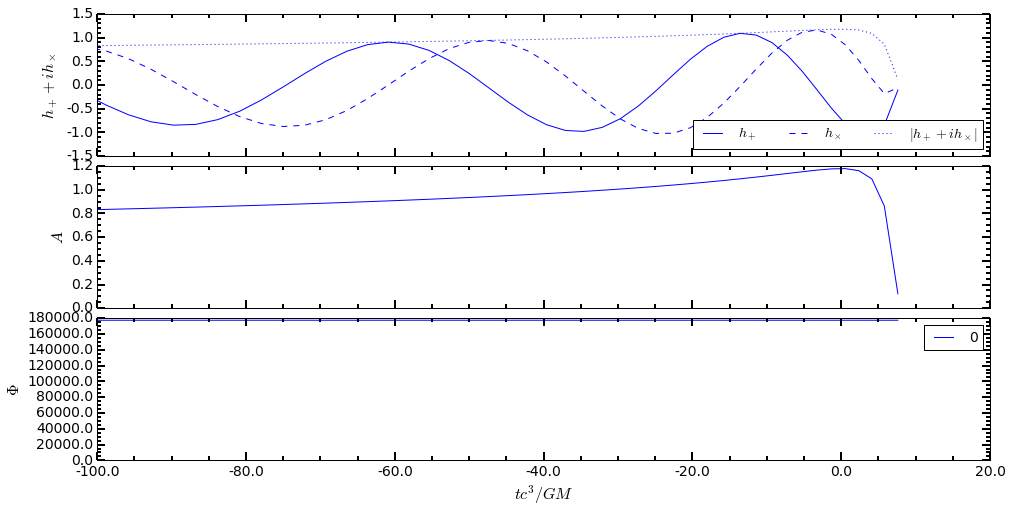

In [6]:
params = [1.0, 50.0, 50.0]
waveforms = rom.evaluate(params)

xlim=[-100, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

# Everything below will not run

# Check that ROM exactly reproduces the training set waveforms

In [12]:
# Get training set
ts_filename = 'teob_runs_cheb16_f10_v2_%d.hdf5'
memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

[  1.00000000e+00   5.00000000e+03   5.00000000e+03]


/home/bdlackey/virtenvs/python-notebook/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


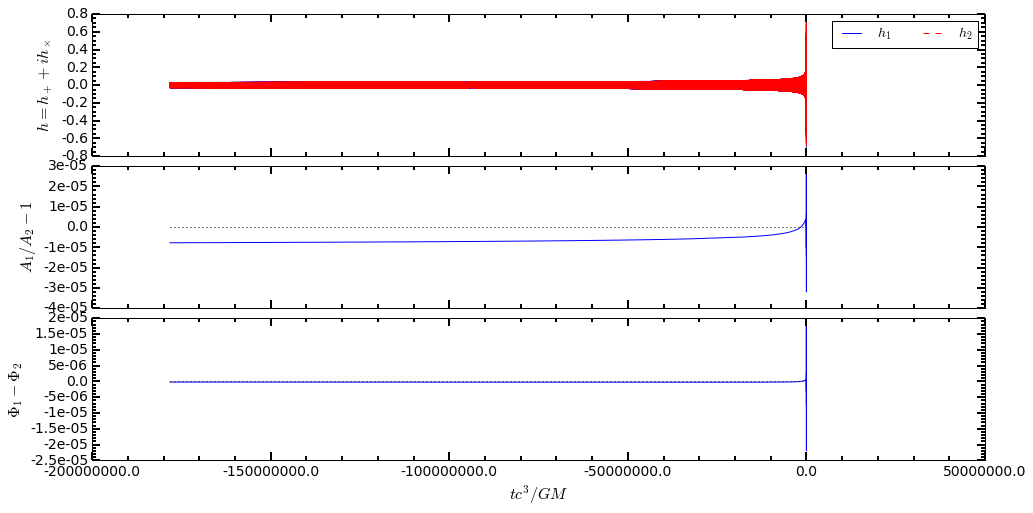

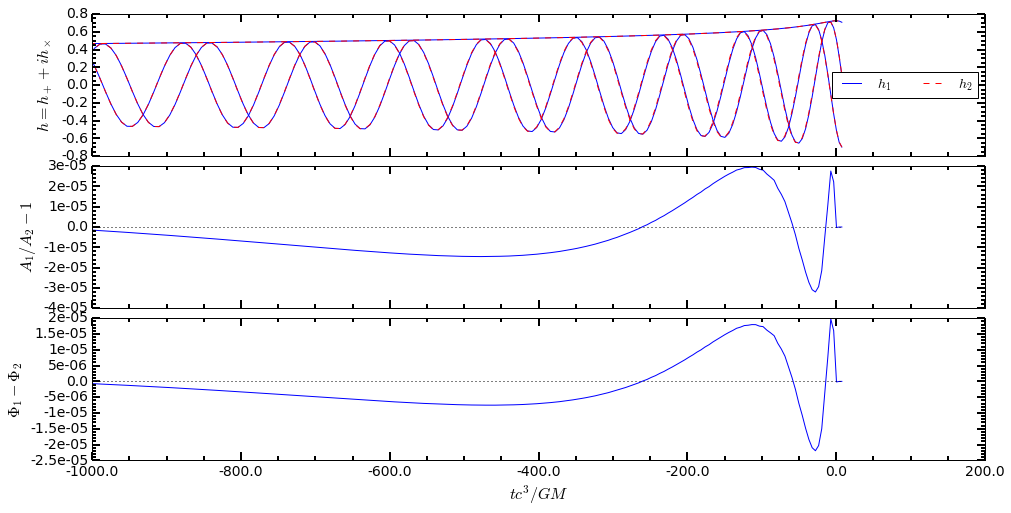

In [13]:
i=4095
params = ts.get_waveform_data(i, data='parameters')
print params
htrue = ts.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=20)

# Compare the waveform to it's projection
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

# Compare the waveform to it's projection
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlim=[-1000, 200], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

[  1.00000000e+00   5.00000000e+03   5.00000000e+03]


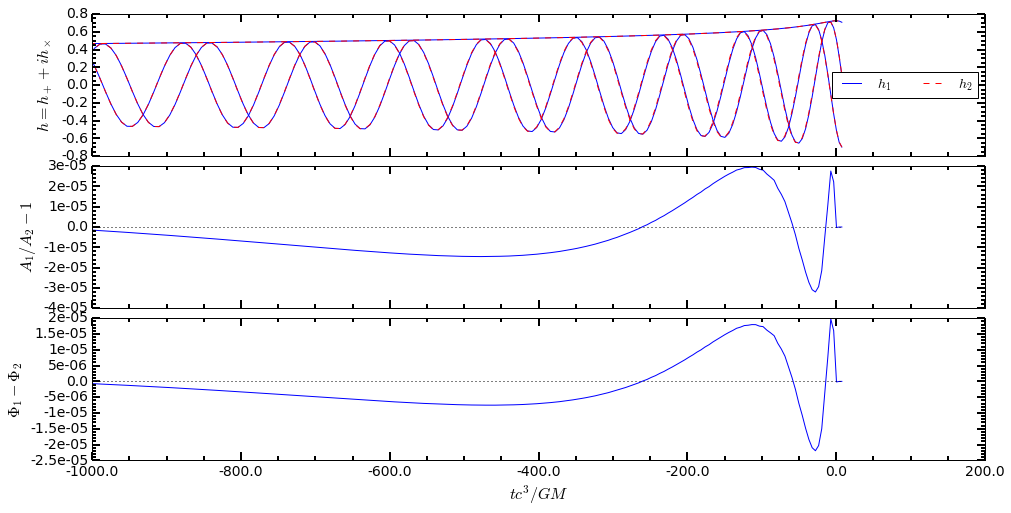

In [14]:
i=4095
params = ts.get_waveform_data(i, data='parameters')
print params
htrue = ts.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=20)

# Compare the waveform to it's projection
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlim=[-1000, 200], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

# Compare results with randomly sampled waveform set

In [56]:
training_set_dir = '/home/bdlackey/teob/teob_runs_rand_10000'
ts_filename = 'teob_runs_rand_10000_%d.hdf5'
memb_size=2**34-1
param_names = ['q', 'LambdaA', 'LambdaB']
ts_rand = eob.get_eob_training_set(training_set_dir, ts_filename, memb_size=memb_size, 
                              param_names=param_names, samples_per_cycle=100)
ts_rand.close()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900


In [15]:
filename = 'teob_runs_rand_10000_%d.hdf5'
memb_size=2**34-1
ts_rand = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [28]:
ts_rand.get_waveform_data(0).time[0]

-105645.13935292972

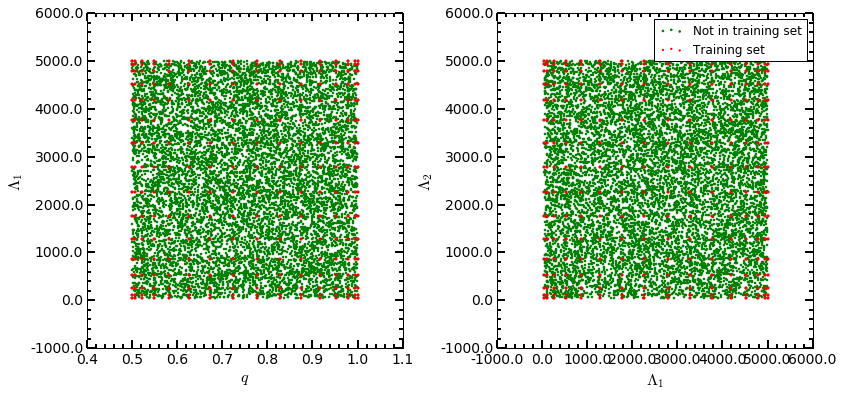

In [16]:
fig = plt.figure(figsize=(13, 6))

axes = fig.add_subplot(121)
axes.scatter(np.array(ts_rand.get_parameters())[:, 0], np.array(ts_rand.get_parameters())[:, 1], 
             marker='.', s=10, color='g')
axes.scatter(np.array(ts.get_parameters())[:, 0], np.array(ts.get_parameters())[:, 1], 
             marker='.', s=6, color='r')
axes.set_xlabel(r'$q$', fontsize=16)
axes.set_ylabel(r'$\Lambda_1$', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)


axes = fig.add_subplot(122)
axes.scatter(np.array(ts_rand.get_parameters())[:, 1], np.array(ts_rand.get_parameters())[:, 2], 
             marker='.', s=10, color='g', label='Not in training set')
axes.scatter(np.array(ts.get_parameters())[:, 1], np.array(ts.get_parameters())[:, 2], 
             marker='.', s=6, color='r', label='Training set')
axes.set_xlabel(r'$\Lambda_1$', fontsize=16)
axes.set_ylabel(r'$\Lambda_2$', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)
axes.legend()

subplots_adjust(wspace=0.3)

In [17]:
def max_amp_phase_error(htrue, hrom, samples_per_cycle=100.0):
    """Calculate the maximum amplitude and phase error of the ROM waveform.
    """
    # Resample waveforms to have the same times
    htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=samples_per_cycle)
    
    # Relative amplitude error, phase difference error
    amperror = np.abs(hrom_res.amp/htrue_res.amp - 1.0)
    phaseerror = np.abs(hrom_res.phase - htrue_res.phase)
    
    iamperrmax = amperror.argmax()
    tamperrmax = htrue_res.time[iamperrmax]
    amperrmax = amperror[iamperrmax]
    
    iphaseerrmax = phaseerror.argmax()
    tphaseerrmax = htrue_res.time[iphaseerrmax]
    phaseerrmax = phaseerror[iphaseerrmax]
    
    return iamperrmax, tamperrmax, amperrmax, iphaseerrmax, tphaseerrmax, phaseerrmax

In [25]:
samples_per_cycle = 20.0

params_list = []
amperr_list = []
phaseerr_list = []

for i in range(ts_rand.get_len()):
    #for i in range(5000):
    #print i,
    if i%100==0: print i,
    htrue = ts_rand.get_waveform_data(i)
    
    # Get parameter values and waveform from training_set_rand
    params = ts_rand.get_waveform_data(i, data='parameters')
    
    # Get ROM waveform
    hrom = rom.evaluate(params)
    
    amperr, phaseerr = max_amp_phase_error(htrue, hrom, samples_per_cycle=samples_per_cycle)[2::3]    
    params_list.append(params)
    amperr_list.append(amperr)
    phaseerr_list.append(phaseerr)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900


In [26]:
#params_list

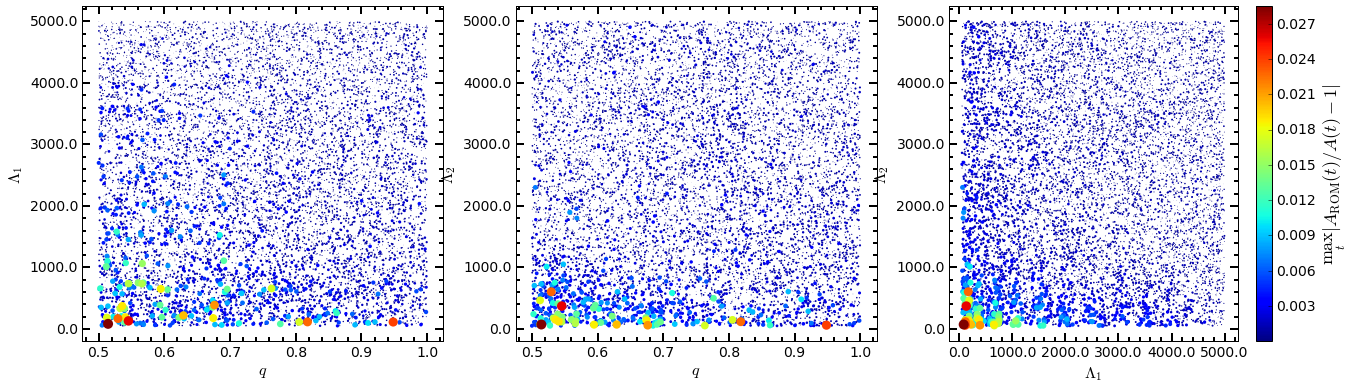

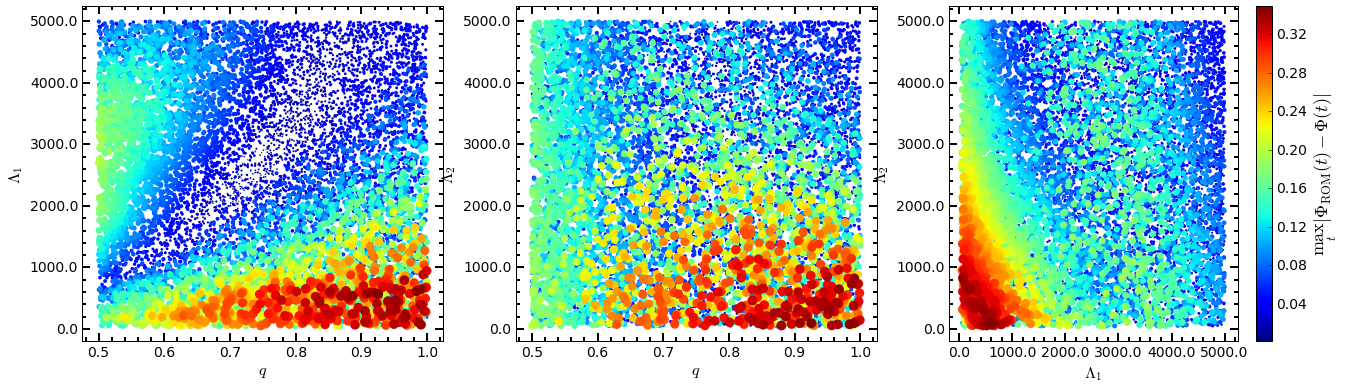

In [27]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t |A_{\rm ROM}(t)/A(t) - 1|$')


# Phase errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm ROM}(t)-\Phi(t)|$')

In [30]:
imax = np.argmax(amperr_list)
print imax, params_list[imax], amperr_list[imax]

309 [  0.51431572  82.730718    72.678998  ] 0.0284826140005


In [31]:
imax = np.argmax(phaseerr_list)
print imax, params_list[imax], phaseerr_list[imax]

8561 [   0.92546319  568.549881     93.526876  ] 0.349256761962


[   0.92546319  568.549881     93.526876  ]


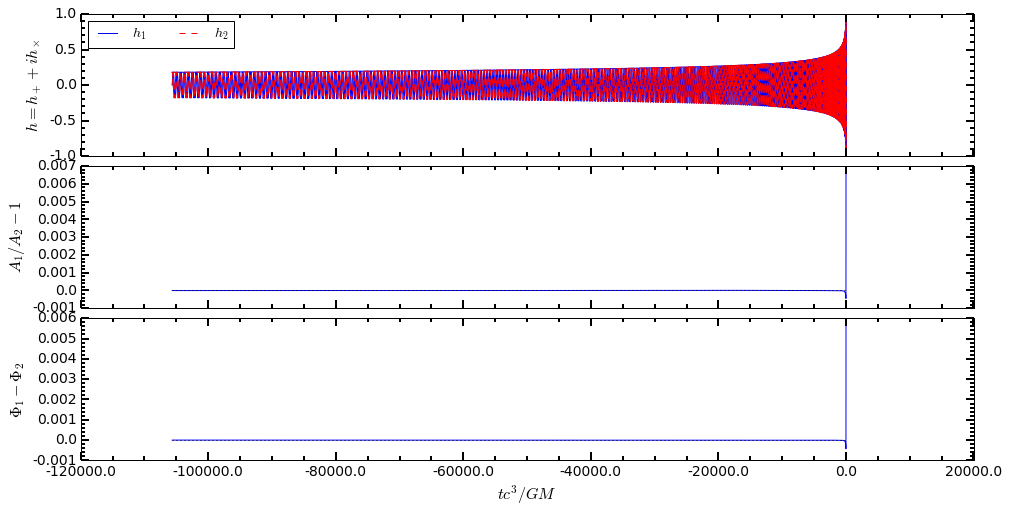

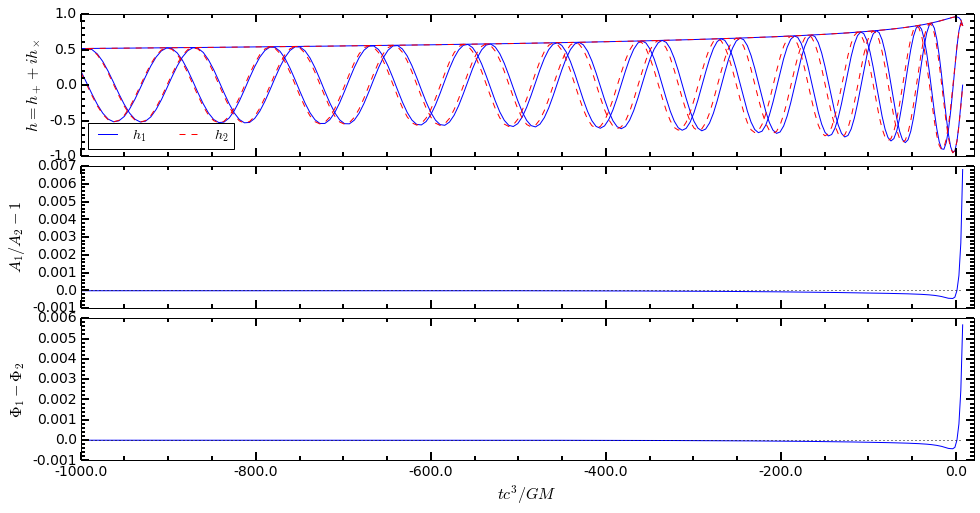

In [32]:
i=8561
#i=imax
params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=20)

# Compare ROM to the true waveform
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlim=None, xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlim=[-1000, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

#Calculate the projection of training set onto reduced basis and plot it

In [52]:
rblist = [rb.get_waveform_data(i) for i in range(rb.get_len())]

NameError: name 'rb' is not defined

In [68]:
i=1234

# Get true waveform
params = ts.get_waveform_data(i, data='parameters')
htrue = ts.get_waveform_data(i)

# Calculate projection of waveform onto reduced basis
add = tdwave.add
scalar_multiply = tdwave.scalar_multiply
inner_product = tdwave.inner_product
proj = greedy.projection(htrue, rblist, add, scalar_multiply, inner_product)

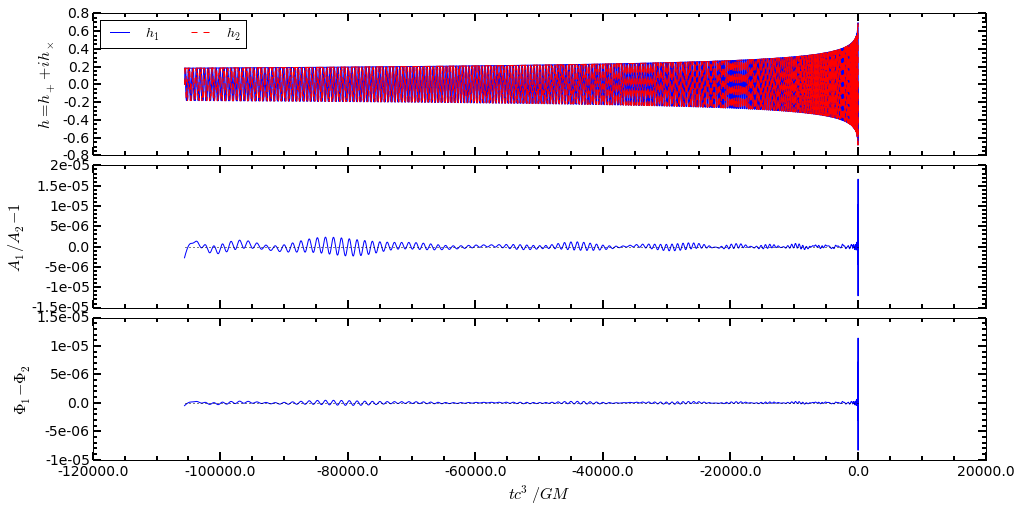

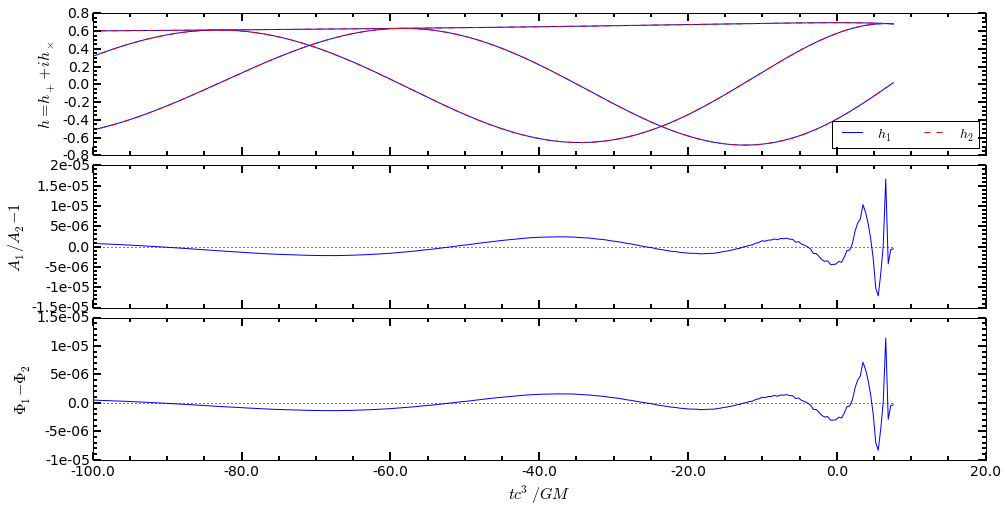

In [69]:
# Compare ROM to its projection onto the reduced basis
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, proj, htrue, imag=False, mag=False, 
                                         xlim=None, xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, proj, htrue, imag=False, mag=False, 
                                         xlim=[-100, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

In [77]:
add = tdwave.add
scalar_multiply = tdwave.scalar_multiply
inner_product = tdwave.inner_product

params_list = []
amperr_list = []
phaseerr_list = []

#for i in range(ts.get_len()):
for i in range(100):
    print i,
    if i%100==0: print i,
    # Get true waveform
    params = ts.get_waveform_data(i, data='parameters')
    htrue = ts.get_waveform_data(i)
    # Calculate projection of waveform onto reduced basis
    proj = greedy.projection(htrue, rblist, add, scalar_multiply, inner_product)
    amperr, phaseerr = max_amp_phase_error_with_proj(htrue, rblist)[2::3]  
    params_list.append(params)
    amperr_list.append(amperr)
    phaseerr_list.append(phaseerr)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.5, right=0.5
  'left=%s, right=%s') % (left, right))


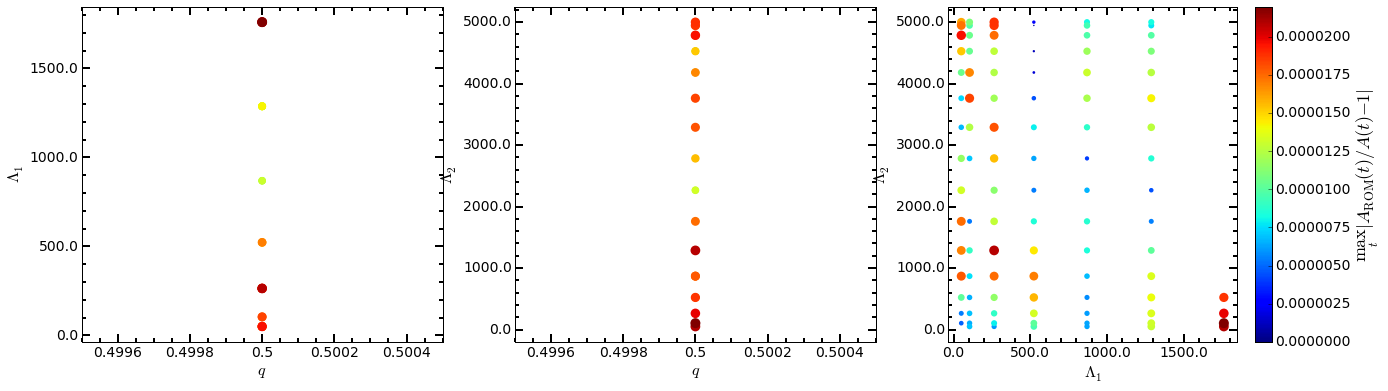

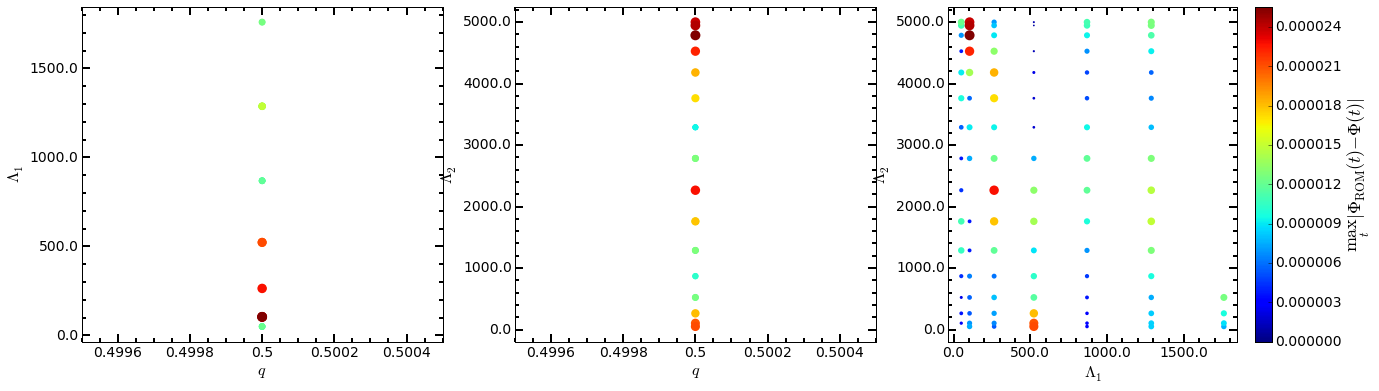

In [78]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t |A_{\rm ROM}(t)/A(t) - 1|$')


# Phase errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm ROM}(t)-\Phi(t)|$')

#Calculate the projection of random set onto reduced basis and plot it

In [70]:
def resample_waveform(h, h_fixed):
    """Resample h so that the time samples are the same as hfixed.
    This function assumes that t=0 corresponds to the maximum amplitude.
    
    Parameters
    ----------
    h : TimeDomainWaveform
    h_fixed : TimeDomainWaveform
    
    Returns
    -------
    h_new : TimeDomainWaveform
    """
    # Copy the waveform so you don't overwrite it.
    h_new = h.copy()
    
    # Resample
    h_new.resample(time_new=h_fixed.time)
    
    # Shift phase to be 0 at beginning for both
    h_new.phase_shift(remove_start_phase=True)
    
    return h_new

In [73]:
def max_amp_phase_error_with_proj(htrue, rblist):
    """Calculate the maximum amplitude and phase error of the ROM waveform.
    """
    # Resample waveforms to have the same times
    htrue_res = resample_waveform(htrue, rblist[0])

    # Calculate projection of waveform onto reduced basis
    add = tdwave.add
    scalar_multiply = tdwave.scalar_multiply
    inner_product = tdwave.inner_product
    proj = greedy.projection(htrue_res, rblist, add, scalar_multiply, inner_product)
    
    # Relative amplitude error, phase difference error
    amperror = np.abs(proj.amp/htrue_res.amp - 1.0)
    phaseerror = np.abs(proj.phase - htrue_res.phase)
    
    iamperrmax = amperror.argmax()
    tamperrmax = htrue_res.time[iamperrmax]
    amperrmax = amperror[iamperrmax]
    
    iphaseerrmax = phaseerror.argmax()
    tphaseerrmax = htrue_res.time[iphaseerrmax]
    phaseerrmax = phaseerror[iphaseerrmax]
    
    return iamperrmax, tamperrmax, amperrmax, iphaseerrmax, tphaseerrmax, phaseerrmax

In [71]:
i=1234

# Get true waveform
params = ts_rand.get_waveform_data(i, data='parameters')
htrue = ts_rand.get_waveform_data(i)

# Resample waveforms to have the same times
htrue_res = resample_waveform(htrue, rblist[0])

# Calculate projection of waveform onto reduced basis
add = tdwave.add
scalar_multiply = tdwave.scalar_multiply
inner_product = tdwave.inner_product
proj = greedy.projection(htrue_res, rblist, add, scalar_multiply, inner_product)

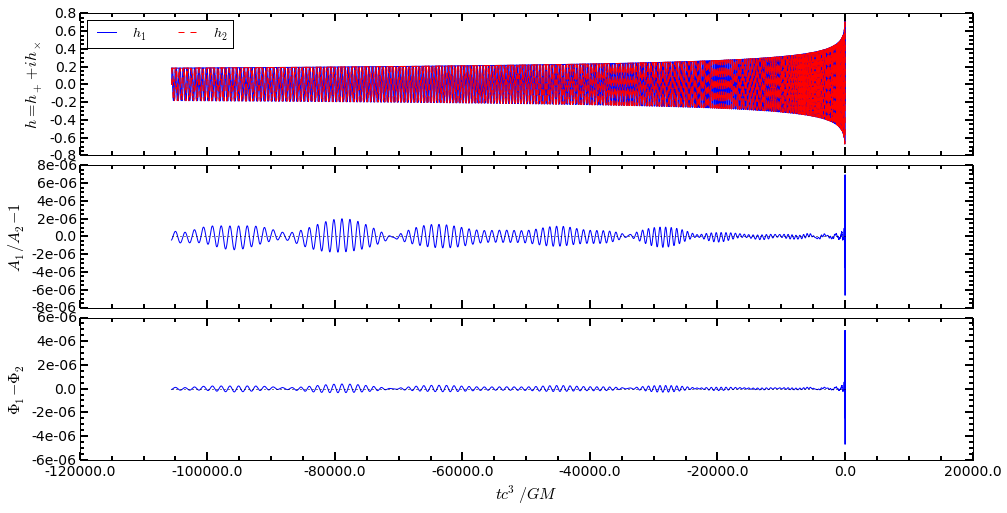

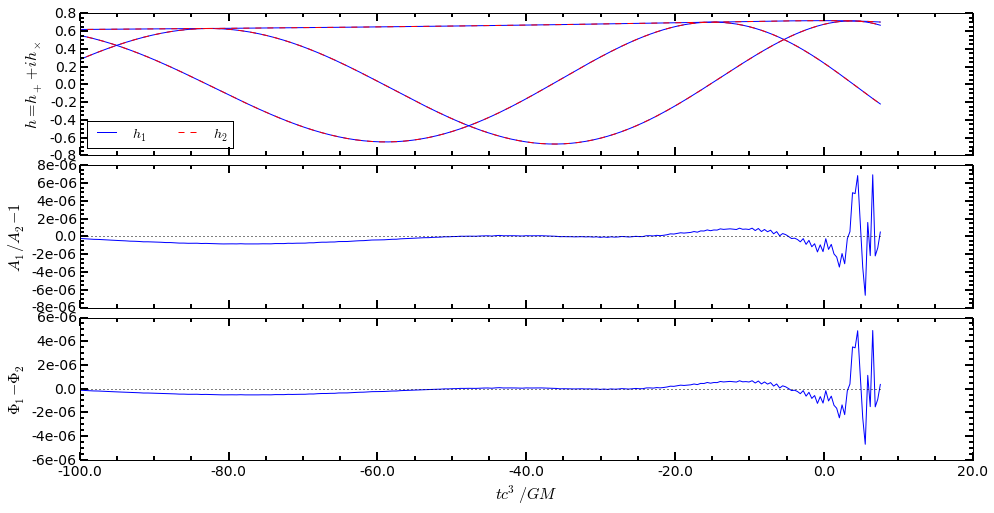

In [72]:
# Compare ROM to its projection onto the reduced basis
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, proj, htrue_res, imag=False, mag=False, 
                                         xlim=None, xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_difference(fig, proj, htrue_res, imag=False, mag=False, 
                                         xlim=[-100, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

In [74]:
i=1234

# Get true waveform
params = ts_rand.get_waveform_data(i, data='parameters')
htrue = ts_rand.get_waveform_data(i)
max_amp_phase_error_with_proj(htrue, rblist)

(27501,
 6.5788724923247557,
 6.9458066747074554e-06,
 27502,
 6.9142727969271069,
 1.4334340676214197e-05)

In [75]:
params_list = []
amperr_list = []
phaseerr_list = []

#for i in range(ts_rand.get_len()):
for i in range(100):
    print i,
    if i%100==0: print i,
    params = ts_rand.get_waveform_data(i, data='parameters')
    htrue = ts_rand.get_waveform_data(i)
    amperr, phaseerr = max_amp_phase_error_with_proj(htrue, rblist)[2::3]  
    params_list.append(params)
    amperr_list.append(amperr)
    phaseerr_list.append(phaseerr)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


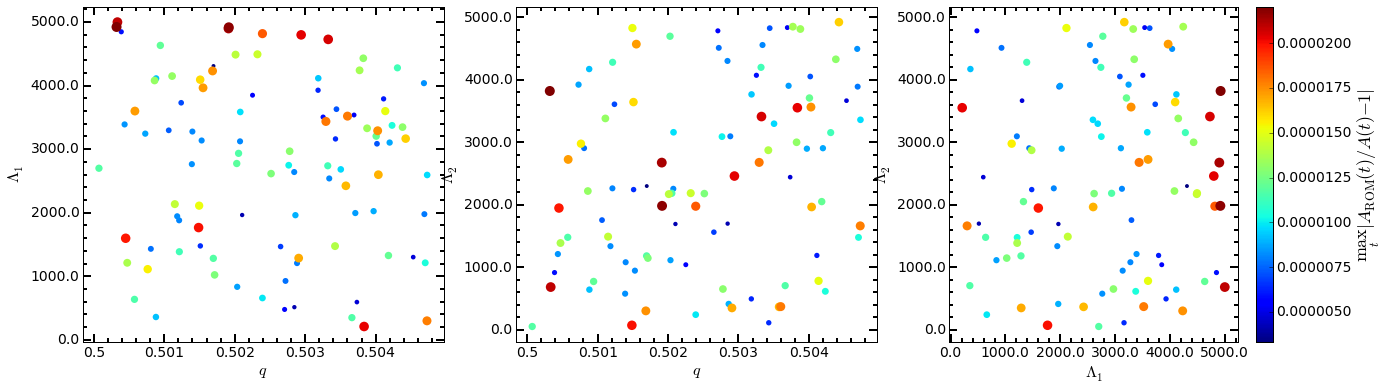

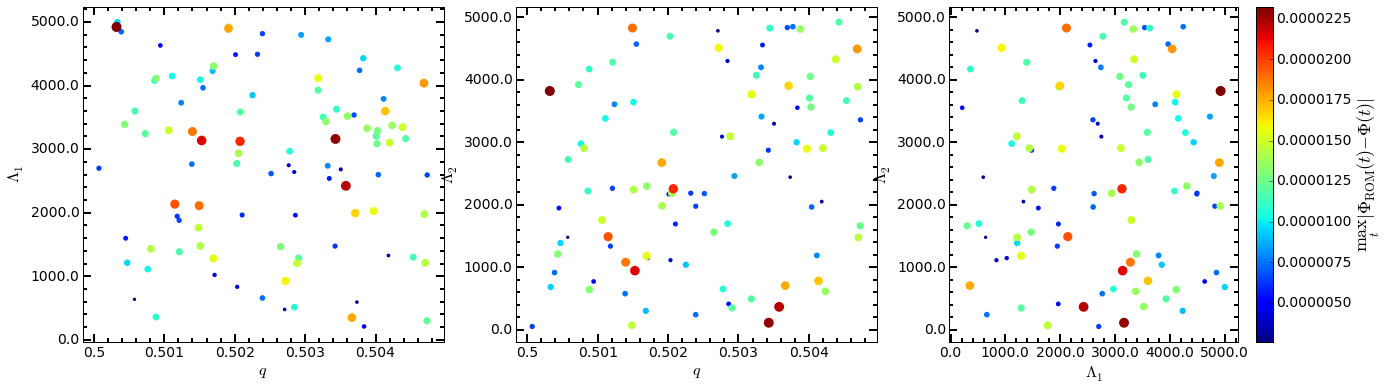

In [76]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, amperr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t |A_{\rm ROM}(t)/A(t) - 1|$')


# Phase errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 1, r'$q$', r'$\Lambda_1$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 0, 2, r'$q$', r'$\Lambda_2$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_list, phaseerr_list, 1, 2, r'$\Lambda_1$', r'$\Lambda_2$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm ROM}(t)-\Phi(t)|$')

# Chebyshev coefficients

In [82]:
def chebyshev_interpolation3d_coefficients(f_ijk, params_min, params_max):
    """Generate a function of N parameters that interpolates a uniformly spaced Nd array.
    
    Parameters
    ----------
    data : 3d array
        Data to interpolate.
    params_min : 1d array of length 3
        Minimum value of each parameter.
    params_max : 1d array of length 3
        Maximum value of each parameter.
    
    Returns
    -------
    interp: function(params)
        Interpolating function that takes params
        (1d array of the parameter values at which you want to interpolate the data).
    """
    cheb_approx = cheb.ChebyshevApproximation()
    # Get the bounds of the parameter space
    cheb_approx.low = params_min
    cheb_approx.high = params_max
    cheb_approx.Ndim = 3
    cheb_approx.f_grid = f_ijk
    # Calculate the Chebyshev coefficients
    cheb_approx.calculate_chebyshev_coefficients()
    
    return cheb_approx.coefficients

In [138]:
nodei = 7

f_ijk = train_phase_grid[..., nodei]
params = param_grid
params_min = params[0, 0, 0]
params_max = params[-1, -1, -1]
c_lmn = chebyshev_interpolation3d_coefficients(f_ijk, params_min, params_max)

In [139]:
#carray = np.array([[i, np.abs(c_lmn[i, i, i])] for i in range(len(c_lmn))])

In [141]:
#carray = np.array([[i, np.max(np.abs(c_lmn[i, :, :].flatten()))] for i in range(len(c_lmn))])

###Make a plot like this for the coefficients of known functions and see how the value drops with the index

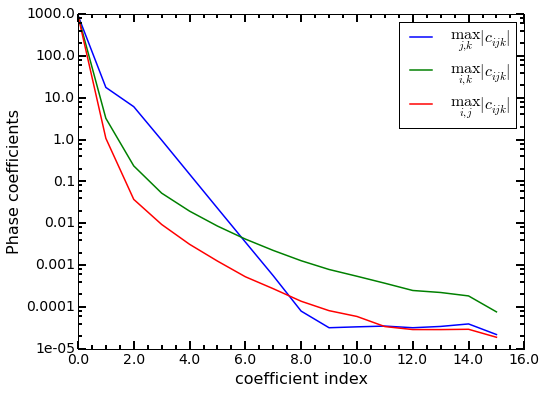

In [142]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

carray = np.array([[i, np.max(np.abs(c_lmn[i, :, :].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{j,k}|c_{ijk}|$')

carray = np.array([[i, np.max(np.abs(c_lmn[:, i, :].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{i,k}|c_{ijk}|$')

carray = np.array([[i, np.max(np.abs(c_lmn[:, :, i].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{i, j}|c_{ijk}|$')

axes.set_xlabel(r'coefficient index', fontsize=16)
axes.set_ylabel(r'Phase coefficients', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)
axes.legend(fontsize=16, loc='best')

In [ ]:
def plot_greedy_error(axes, sigma_list):
    """Plot the greedy error as a function of the number of reduced bases.
    
    Parameters
    ----------
    axes : axes object
        The axes you want to put the plot on.
    sigma_list : list of floats
        The greedy errors
    """
    
    axes.semilogy(sigma_list, color='k', ls='-', lw=1.5)
    #axes.semilogy(sigma_list, color='b', marker='o')
    
    axes.set_xlabel(r'Waveform index $m$', fontsize=16)
    axes.set_ylabel(r'Greedy error $\sigma_m$', fontsize=16)
    axes.set_xticklabels(axes.get_xticks(), fontsize=14)
    axes.set_yticklabels(axes.get_yticks(), fontsize=14)
    axes.minorticks_on()
    axes.tick_params(which='major', width=2, length=8)
    axes.tick_params(which='minor', width=2, length=4)
